<a href="https://colab.research.google.com/github/tylerlum/Tray_Image_Classifier_A/blob/master/TensorFlow_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install googledrivedownloader

In [3]:
# Download .7z files of images
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1smbsz8AJ-VGhKbtr7NTvAVzTI3auI_C4',
                                    dest_path='./tray-data/HiRes.7z')
gdd.download_file_from_google_drive(file_id='1wZ-AHv4yx_lXGeaqKzbTNuap6mpESyEq',
                                    dest_path='./tray-data/LoRes.7z')

!ls /content/tray-data

In [4]:
# Extract.7z file
!7z x /content/tray-data/HiRes.7z 
!7z x /content/tray-data/LoRes.7z 
%cd /content
!mv data_HiRes tray-data
!mv data_LoRes tray-data


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/tray-data/                             1 file, 987230795 bytes (942 MiB)

Extracting archive: /content/tray-data/file.7z
--
Path = /content/tray-data/file.7z
Type = 7z
Physical Size = 987230795
Headers Size = 38637
Method = LZMA2:26
Solid = +
Blocks = 1

  0%      7% 437 - data_HiRes/multi/L06_L10/L06_L10_006.png                                                    14% 774 - data_HiRes/multi/L08_L09_L11/L08_L09_L11_143.png                                                           

In [0]:
!mv data_HiRes tray-data

In [0]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [135]:
# Setup for one hot encoding values
%cd /content/tray-data/data_LoRes/single
one_hot_encode = {}
types = [directory for directory in os.listdir('.')]
types.sort()
i = 0
for type in types:
  one_hot_encode[type] = i
  i = i + 1

/content/tray-data/data_LoRes/single


In [136]:
# Convert pngs into numpy arrays in full_dataset dict
%cd /content/tray-data/data_LoRes/single
import os
full_dataset = {}
P = 0
for directory in os.listdir('.'):
  x_data = []
  y_data = []
  for png in os.listdir('/content/tray-data/data_LoRes/single/' + directory):
    im = cv2.imread('/content/tray-data/data_LoRes/single/' + directory + '/' + png)
    x_data.append(im)
    a = np.zeros((len(types), 1))
    a[one_hot_encode[directory]] = 1
    y_data.append(a)
  full_dataset[str(directory) + "_x"] = x_data
  full_dataset[str(directory) + "_y"] = y_data
  


/content/tray-data/data_LoRes/single


(64, 64, 3)


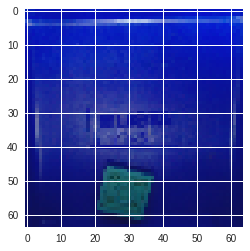

In [137]:
# Example image
print(full_dataset['L11_x'][0].shape)
plt.imshow(full_dataset['L11_x'][10])

plt.imshow(b[1])

In [138]:
# Fill in training and test data sets

# Initialize 
X_train = None
X_test = None
Y_train = None
Y_test = None
  
# Choose number of pictures and classes
num_pictures = 70  # per class
num_classes = 6  # number of classes used for recognition

class_num = 0
keys_x = [key for key in full_dataset if not key.find("_x") == -1]
keys_x.sort()
for key_x in keys_x:
  # Finish after getting class_num classes
  if class_num >= 6:
    break
  class_num = class_num + 1
  i = 0
  
  # Add images from this class
  for im in full_dataset[key_x]:
    
    # Add to training set
    if i <= num_pictures:
      # Initialize array
      if X_train is None:
        X_train = np.array([im])
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_train = np.array([a])
      # Append to array
      else:
        X_train = np.append(X_train, [im], axis=0)
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_train = np.append(Y_train, [a], axis=0)
        #print(X_train.shape)
        
    # Add to test set
    elif i <= num_pictures * 3 / 2:  ## 3:2 ratio of train:test size
      # Initialize array
      if X_test is None:
        X_test = np.array([im])
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_test = np.array([a])
      # Append to array
      else:
        X_test = np.append(X_test, [im], axis=0)
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_test = np.append(Y_test, [a], axis=0)
        #print(X_test.shape)
    else:
      break
    i = i + 1
    
Y_train = Y_train[:, :, 0].T
Y_test = Y_test[:, :, 0].T
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(426, 64, 64, 3)
(6, 426)
(196, 64, 64, 3)
(6, 196)


[0. 0. 1. 0. 0. 0.]


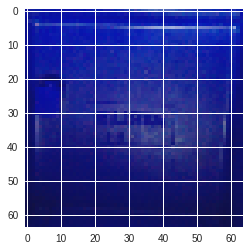

In [139]:
# Example image and label
index = 180
plt.imshow(X_train[index])
print(Y_train[:, index])

In [0]:
# Randomize order in datasets (TODO: shuffle earlier on, so mix train and test)
import random
import copy

## Mix up data
num_switches = 100
for i in range(0, num_switches):
  rand1 = random.randint(0, X_train.shape[0]-1)
  rand2 = random.randint(0, X_train.shape[0]-1)
  temp = copy.copy(X_train[rand1])
  X_train[rand1] = X_train[rand2]
  X_train[rand2] = temp
  
  temp = copy.copy(Y_train[:, rand1])
  Y_train[:, rand1] = Y_train[:, rand2]
  Y_train[:, rand2] = temp
  
  #print(str(rand1) + " " + str(rand2))
  
for i in range(0, num_switches):
  rand1 = random.randint(0, X_test.shape[0]-1)
  rand2 = random.randint(0, X_test.shape[0]-1)
  temp = copy.copy(X_test[rand1])
  X_test[rand1] = X_test[rand2]
  X_test[rand2] = temp
  
  temp = copy.copy(Y_test[:, rand1])
  Y_test[:, rand1] = Y_test[:, rand2]
  Y_test[:, rand2] = temp
  
  #print(str(rand1) + " " + str(rand2))

[1. 0. 0. 0. 0. 0.]


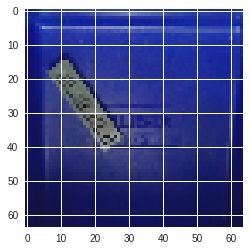

In [140]:
# Example view test image and label
index = 12
plt.imshow(X_test[index])
print(Y_test[:, index])

[0. 0. 1. 0. 0. 0.]


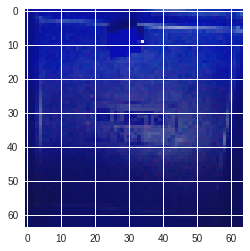

In [141]:
# Example view train image and label
index = 190
plt.imshow(X_train[index])
print(Y_train[:, index])

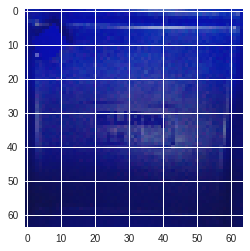

In [144]:
plt.imshow(full_dataset['L03_x'][0])

In [0]:
# Reshape the training and test examples 
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = X_train_flatten/255.
test_x = X_test_flatten/255.

train_y = Y_train
test_y = Y_test

In [146]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (12288, 426)
test_x's shape: (12288, 196)
train_y's shape: (6, 426)
test_y's shape: (6, 196)


In [0]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    ### END CODE HERE ###
    
    return X, Y

In [0]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 316875]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [23, 12]
                        b3 : [23, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [20, 12288], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [20, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 20], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer=tf.zeros_initializer())
#     W4 = tf.get_variable("W4", [23, 35], initializer=tf.contrib.layers.xavier_initializer(seed=1))
#     b4 = tf.get_variable("b4", [23, 1], initializer=tf.zeros_initializer())
#     W4 = tf.get_variable("W4", [30, 35], initializer=tf.contrib.layers.xavier_initializer(seed=1))
#     b4 = tf.get_variable("b4", [30, 1], initializer=tf.zeros_initializer())
#     W5 = tf.get_variable("W5", [23, 30], initializer=tf.contrib.layers.xavier_initializer(seed=1))
#     b5 = tf.get_variable("b5", [23, 1], initializer=tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
#                   "W4": W4,
#                   "b4": b4,
#                   "W5": W5,
#                   "b5": b5}
    
    return parameters

In [0]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
#     W4 = parameters['W4']
#     b4 = parameters['b4']
#     W5 = parameters['W5']
#     b5 = parameters['b5']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
#     A3 = tf.nn.relu(Z3)                                              # A2 = relu(Z2)
#     Z4 = tf.add(tf.matmul(W4, A3), b4)
#     A4 = tf.nn.relu(Z4)                                              # A2 = relu(Z2)
#     Z5 = tf.add(tf.matmul(W5, A4), b5)

    ### END CODE HERE ###
    
    return Z3

In [0]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z5, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z5)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    print(Z5.shape)
    print(Y.shape)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.00001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    

    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        saver = tf.train.Saver()
        saver.save(sess, './' + 'model.checkpoint')
        print ("Model saved")
        return parameters

(6, ?)
(6, ?)
Cost after epoch 0: 1.528641
Cost after epoch 100: 0.985496
Cost after epoch 200: 0.713107
Cost after epoch 300: 0.488232
Cost after epoch 400: 0.334543
Cost after epoch 500: 0.221023
Cost after epoch 600: 0.148723
Cost after epoch 700: 0.106047
Cost after epoch 800: 0.068475
Cost after epoch 900: 0.049534
Cost after epoch 1000: 0.034253
Cost after epoch 1100: 0.022977
Cost after epoch 1200: 0.016248
Cost after epoch 1300: 0.011671
Cost after epoch 1400: 0.007890


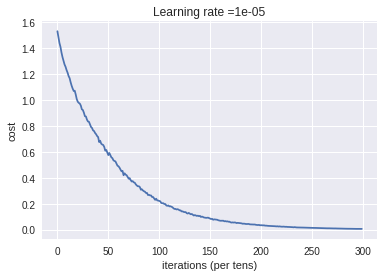

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.9897959
Model saved


In [153]:
parameters = model(train_x, train_y, test_x, test_y)

In [0]:
def random_mini_batches(X_train, Y_train, minibatch_size, seed):
  random.seed(seed)
  retVal = []
  (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
  (n_y, m) = Y_train.shape 
  num_minibatches = m // minibatch_size - 2
  visited = []
  
  for minibatch in range(0, num_minibatches):
    x = np.zeros((n_x, minibatch_size))
    y = np.zeros((n_y, minibatch_size))
    for i in range(0, minibatch_size):
      index = -1
      while index < 0:
        index = random.randint(0, X_train.shape[1] - 1)
        if index in visited:
          index = -1
      visited.append(index)
      x[:, i] = X_train[:, index]
      y[:, i] = Y_train[:, index]
    retVal.append((x, y))
      
  return retVal